## NASA Turbofan Engine Anomaly Detection (FD002)

## Problem Statement

Modern aircraft turbofan engines operate under complex and varying environmental conditions and are equipped with numerous sensors that continuously monitor engine health parameters such as temperature, pressure, speed, and fuel flow. These sensors generate high-dimensional multivariate time-series data throughout the engine’s operational life.

Core Problem:
How can abnormal degradation patterns in turbofan engines be detected early and accurately using only unlabeled multivariate sensor data collected under varying operating conditions?

This problem is addressed as an unsupervised anomaly detection task, where models must learn normal engine behavior and identify deviations that indicate impending failure.

## Objectives

1. Understand and preprocess the FD002 turbofan dataset, including handling multiple operating conditions and sensor measurements.
2. Analyze sensor behavior across engine lifecycles to distinguish normal operation from degradation trends.
3. Model normal engine behavior using machine learning and deep learning techniques without relying on explicit anomaly labels.
4. Detect anomalies by identifying deviations in sensor patterns that indicate abnormal or degraded engine states.
5. Quantify anomaly severity using anomaly scores to reflect the progression of engine health degradation.
6. Evaluate model performance using indirect validation methods such as degradation trends and Remaining Useful Life (RUL) alignment.
7. Improve interpretability by analyzing sensor contributions to detected anomalies.
8. Design a deployable framework suitable for real-time aircraft engine health monitoring systems.

## Dataset Description

The NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) Turbofan Engine Dataset is a benchmark dataset widely used for research in anomaly detection, fault diagnosis, and predictive maintenance. The dataset simulates the complete operational lifecycle of multiple aircraft turbofan engines from a healthy state to system failure.

In this project, the FD002 subset of the dataset is used. FD002 represents engine degradation under multiple operating conditions and a single fault mode. The dataset contains multivariate time-series sensor measurements collected at each operational cycle of the engine. No explicit anomaly labels are provided, making the dataset suitable for unsupervised anomaly detection tasks.

### Dataset Characteristics

| Attribute | Description |
|---------|------------|
| Dataset Name | NASA C-MAPSS Turbofan Engine Dataset |
| Subset Used | FD002 |
| Data Type | Multivariate Time-Series |
| Learning Type | Unsupervised |
| Fault Modes | 1 |
| Operating Conditions | 6 |
| Number of Sensors | 21 |
| Number of Operational Settings | 3 |
| Labels | No explicit anomaly labels |
| End Condition | Engine failure |

## Column Description

Each row in the dataset represents one operational cycle of a turbofan engine.

### Column Structure

| Category | Count |
|--------|------|
| Engine Identifier | 1 |
| Time Cycle | 1 |
| Operational Settings | 3 |
| Sensor Measurements | 21 |
| Total Columns | 26 |




## Importing Libraries

In [6]:
# Numerical and data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Anomaly detection
from sklearn.ensemble import IsolationForest

# Evaluation
from sklearn.metrics import mean_squared_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Utilities
import warnings
warnings.filterwarnings("ignore")

## Data Loading

In [8]:
import pandas as pd

column_names = (
    ["engine_id", "cycle",
     "op_setting_1", "op_setting_2", "op_setting_3"]
    + [f"sensor_{i}" for i in range(1, 22)]
)

train_df = pd.read_csv("CMAPs/train_FD002.txt", sep=r"\s+", header=None)
test_df  = pd.read_csv("CMAPs/test_FD002.txt",  sep=r"\s+", header=None)
rul_df   = pd.read_csv("CMAPs/RUL_FD002.txt",   header=None)

train_df.columns = column_names
test_df.columns  = column_names
rul_df.columns   = ["RUL"]

print("Train:", train_df.shape)
print("Test :", test_df.shape)
print("RUL  :", rul_df.shape)

train_df.head()


Train: (53759, 26)
Test : (33991, 26)
RUL  : (259, 1)


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


## Data Preprocessing

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53759 entries, 0 to 53758
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     53759 non-null  int64  
 1   cycle         53759 non-null  int64  
 2   op_setting_1  53759 non-null  float64
 3   op_setting_2  53759 non-null  float64
 4   op_setting_3  53759 non-null  float64
 5   sensor_1      53759 non-null  float64
 6   sensor_2      53759 non-null  float64
 7   sensor_3      53759 non-null  float64
 8   sensor_4      53759 non-null  float64
 9   sensor_5      53759 non-null  float64
 10  sensor_6      53759 non-null  float64
 11  sensor_7      53759 non-null  float64
 12  sensor_8      53759 non-null  float64
 13  sensor_9      53759 non-null  float64
 14  sensor_10     53759 non-null  float64
 15  sensor_11     53759 non-null  float64
 16  sensor_12     53759 non-null  float64
 17  sensor_13     53759 non-null  float64
 18  sensor_14     53759 non-nu

In [9]:
train_df["engine_id"].nunique()

260

In [6]:
train_df.isna().sum()

engine_id       0
cycle           0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
sensor_20       0
sensor_21       0
dtype: int64

In [7]:
sensor_cols = [c for c in train_df.columns if c.startswith("sensor_")]
sensor_cols

['sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5',
 'sensor_6',
 'sensor_7',
 'sensor_8',
 'sensor_9',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_15',
 'sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21']

In [8]:
sensor_variance = train_df[sensor_cols].var().sort_values()
sensor_variance

sensor_16         0.000022
sensor_10         0.016248
sensor_15         0.561504
sensor_11        10.448229
sensor_5         13.059831
sensor_19        28.773210
sensor_6         29.504469
sensor_21        35.065527
sensor_20        97.403698
sensor_1        696.416652
sensor_17       770.313126
sensor_2       1390.499279
sensor_14      7197.477708
sensor_3      11224.627089
sensor_4      14190.391000
sensor_13     16401.482048
sensor_12     18950.139854
sensor_8      21085.890683
sensor_18     21120.221812
sensor_7      21317.549421
sensor_9     112769.707858
dtype: float64

In [9]:
sensor_variance = train_df[sensor_cols].var().sort_values()
sensor_variance

sensor_16         0.000022
sensor_10         0.016248
sensor_15         0.561504
sensor_11        10.448229
sensor_5         13.059831
sensor_19        28.773210
sensor_6         29.504469
sensor_21        35.065527
sensor_20        97.403698
sensor_1        696.416652
sensor_17       770.313126
sensor_2       1390.499279
sensor_14      7197.477708
sensor_3      11224.627089
sensor_4      14190.391000
sensor_13     16401.482048
sensor_12     18950.139854
sensor_8      21085.890683
sensor_18     21120.221812
sensor_7      21317.549421
sensor_9     112769.707858
dtype: float64

In [11]:
useful_sensors = sensor_variance[sensor_variance > 1e-4].index.tolist()
useful_sensors

['sensor_10',
 'sensor_15',
 'sensor_11',
 'sensor_5',
 'sensor_19',
 'sensor_6',
 'sensor_21',
 'sensor_20',
 'sensor_1',
 'sensor_17',
 'sensor_2',
 'sensor_14',
 'sensor_3',
 'sensor_4',
 'sensor_13',
 'sensor_12',
 'sensor_8',
 'sensor_18',
 'sensor_7',
 'sensor_9']

## Data Cleaning

In [13]:
op_cols = ["op_setting_1", "op_setting_2", "op_setting_3"]

In [15]:
feature_cols = op_cols + sensor_cols

x_train = train_df[feature_cols].copy()
x_test  = test_df[feature_cols].copy()

In [16]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

print(x_train_scaled.shape, x_test_scaled.shape)

(53759, 24) (33991, 24)


## Exploratory Data Analysis

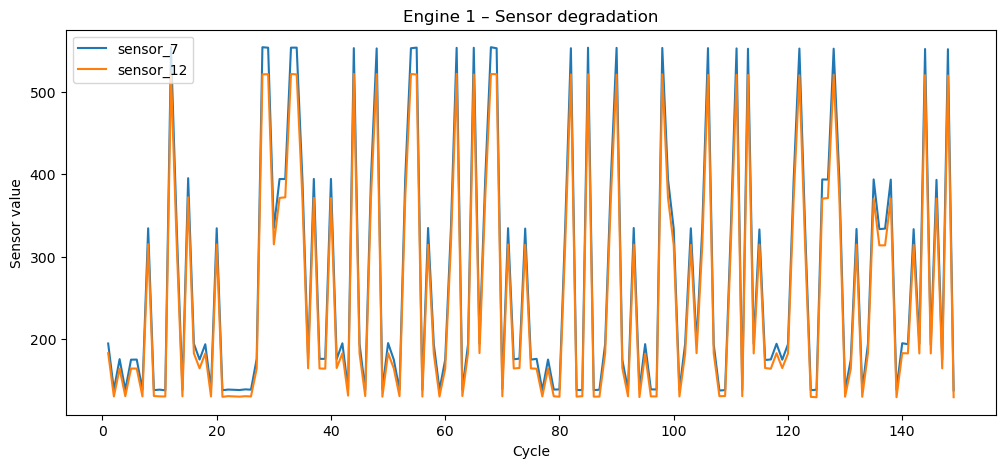

In [18]:
engine_id = train_df["engine_id"].unique()[0]
engine_data = train_df[train_df["engine_id"] == engine_id]

plt.figure(figsize=(12,5))
plt.plot(engine_data["cycle"], engine_data["sensor_7"], label="sensor_7")
plt.plot(engine_data["cycle"], engine_data["sensor_12"], label="sensor_12")
plt.xlabel("Cycle")
plt.ylabel("Sensor value")
plt.title(f"Engine {engine_id} – Sensor degradation")
plt.legend()
plt.show()

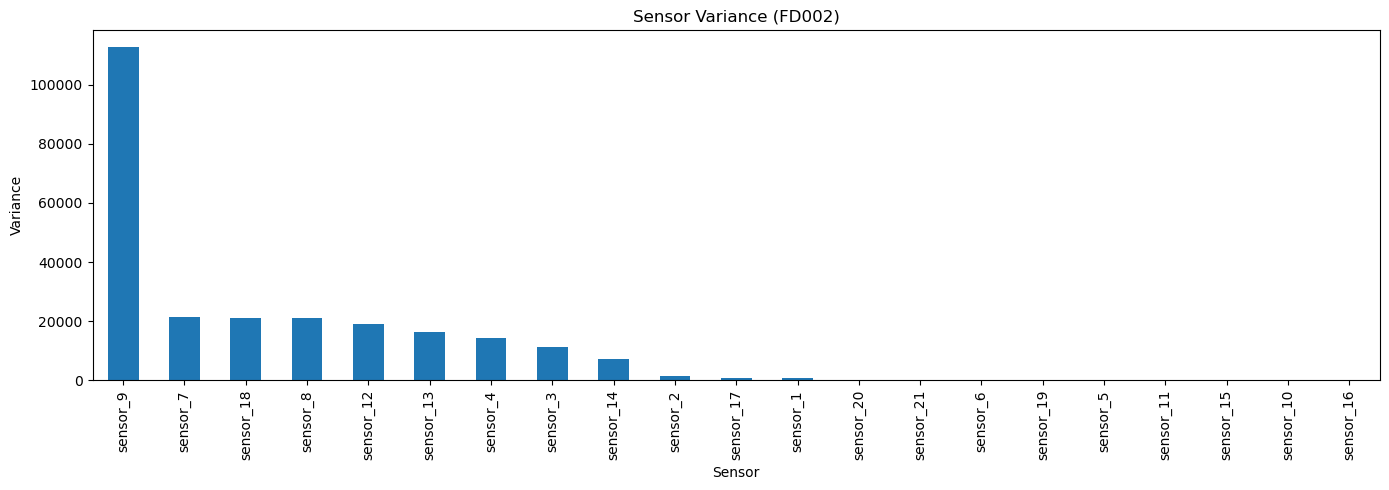

In [20]:
sensor_cols = [c for c in train_df.columns if c.startswith("sensor_")]
sensor_variance = train_df[sensor_cols].var().sort_values(ascending=False)

plt.figure(figsize=(14,5))
sensor_variance.plot(kind="bar")
plt.title("Sensor Variance (FD002)")
plt.ylabel("Variance")
plt.xlabel("Sensor")
plt.tight_layout()
plt.show()

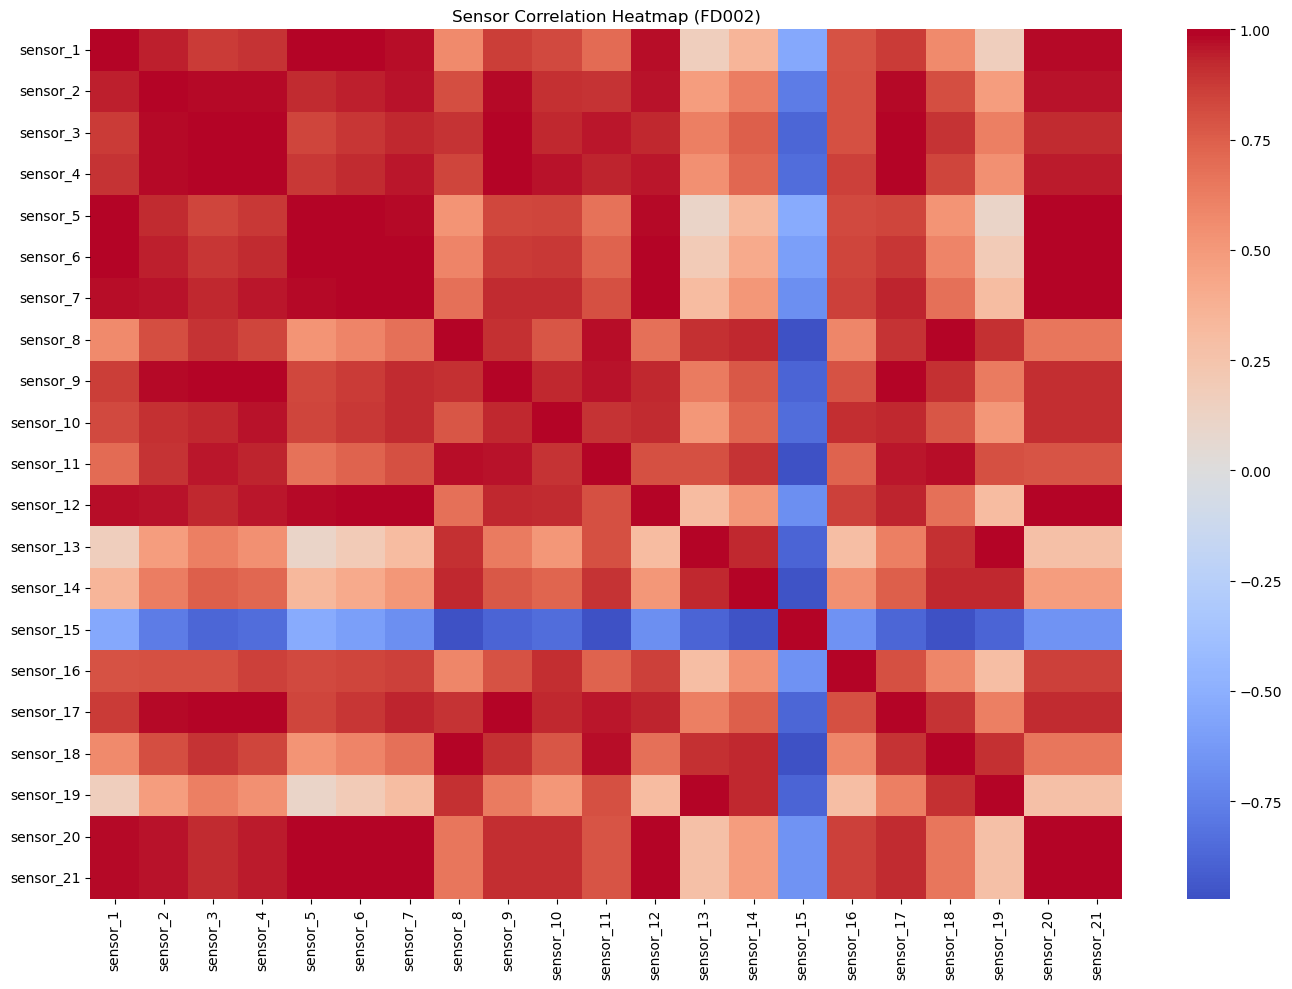

In [21]:
plt.figure(figsize=(14,10))
corr = train_df[sensor_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, cbar=True)
plt.title("Sensor Correlation Heatmap (FD002)")
plt.tight_layout()
plt.show()

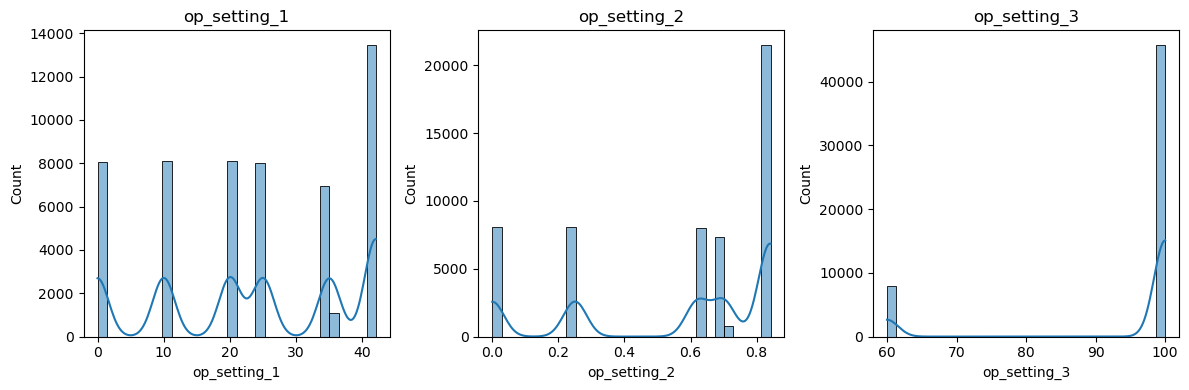

In [22]:
plt.figure(figsize=(12,4))
for i, col in enumerate(op_cols, 1):
    plt.subplot(1,3,i)
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

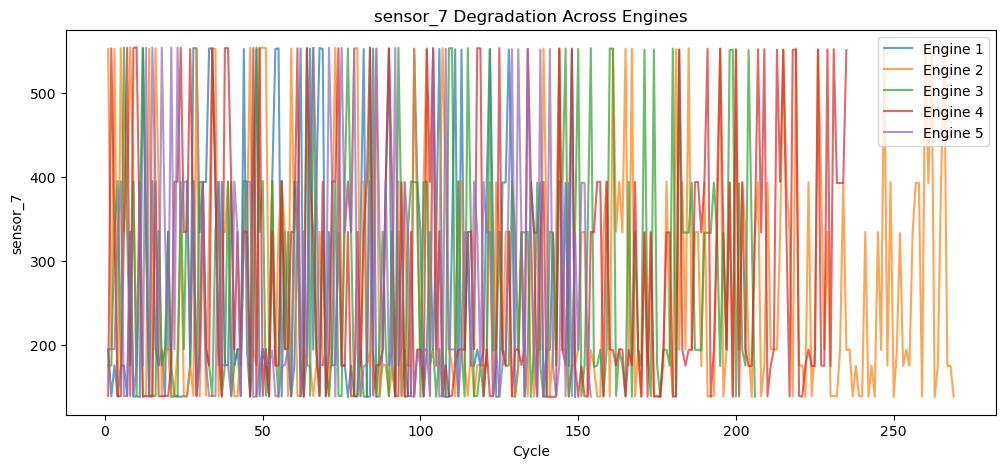

In [23]:
sample_engines = train_df["engine_id"].unique()[:5]

plt.figure(figsize=(12,5))
for eid in sample_engines:
    ed = train_df[train_df["engine_id"] == eid]
    plt.plot(ed["cycle"], ed["sensor_7"], alpha=0.7, label=f"Engine {eid}")

plt.xlabel("Cycle")
plt.ylabel("sensor_7")
plt.title("sensor_7 Degradation Across Engines")
plt.legend()
plt.show()

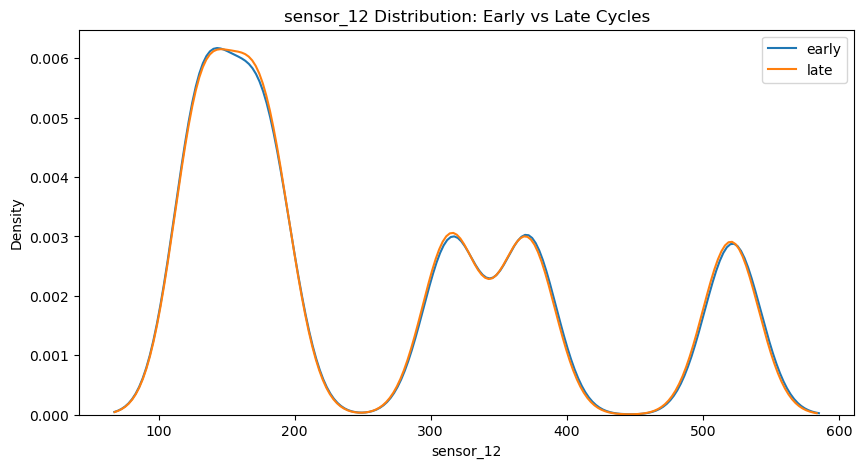

In [24]:
def label_phase(df):
    df = df.copy()
    max_cycle = df["cycle"].max()
    df["phase"] = "mid"
    df.loc[df["cycle"] <= 0.25 * max_cycle, "phase"] = "early"
    df.loc[df["cycle"] >= 0.75 * max_cycle, "phase"] = "late"
    return df

phased = train_df.groupby("engine_id", group_keys=False).apply(label_phase)

plt.figure(figsize=(10,5))
sns.kdeplot(phased[phased["phase"]=="early"]["sensor_12"], label="early")
sns.kdeplot(phased[phased["phase"]=="late"]["sensor_12"], label="late")
plt.title("sensor_12 Distribution: Early vs Late Cycles")
plt.legend()
plt.show()

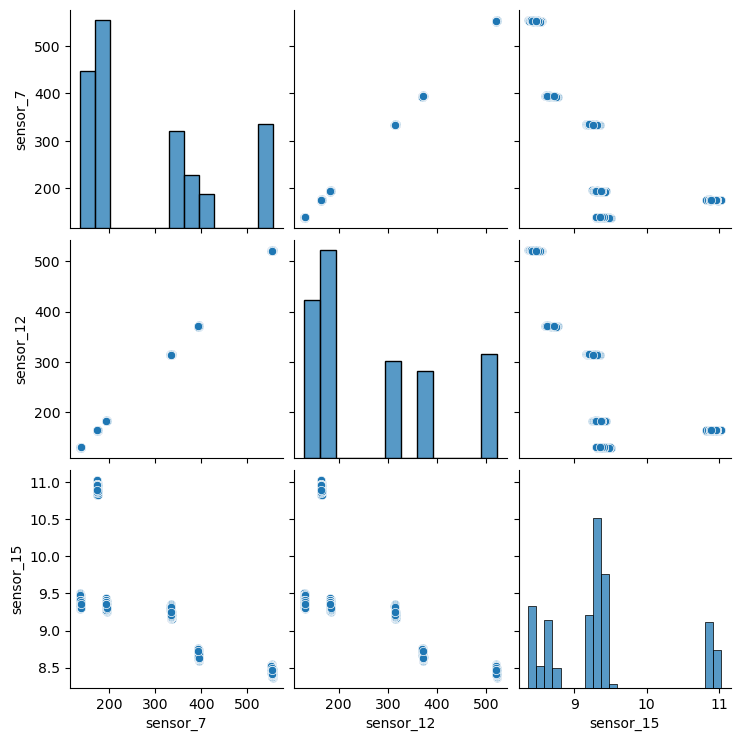

In [25]:
selected = ["sensor_7", "sensor_12", "sensor_15"]
sample_df = train_df[selected].sample(2000, random_state=42)

sns.pairplot(sample_df)
plt.show()

## Base Model - Isolation Forest
Algorithm Type: Machine Learning(Tree Based)

In [27]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(x_train_scaled)

# anomaly scores
train_df["if_score"] = iso_forest.decision_function(x_train_scaled)
test_df["if_score"]  = iso_forest.decision_function(x_test_scaled)

# anomaly flag
threshold_if = train_df["if_score"].quantile(0.05)
train_df["if_anomaly"] = train_df["if_score"] < threshold_if
test_df["if_anomaly"]  = test_df["if_score"] < threshold_if

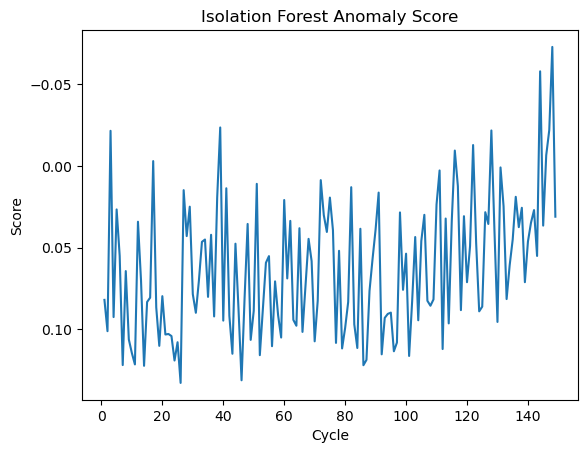

In [28]:
eid = train_df["engine_id"].unique()[0]
ed = train_df[train_df["engine_id"] == eid]

plt.plot(ed["cycle"], ed["if_score"])
plt.gca().invert_yaxis()
plt.title("Isolation Forest Anomaly Score")
plt.xlabel("Cycle")
plt.ylabel("Score")
plt.show()

## DENSE AUTOENCODER
Algorithm type: Deep Learning (unsupervised)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

input_dim = x_train_scaled.shape[1]

inputs = Input(shape=(input_dim,))
encoded = Dense(64, activation="relu")(inputs)
encoded = Dense(32, activation="relu")(encoded)
encoded = Dense(16, activation="relu")(encoded)

decoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(decoded)
outputs = Dense(input_dim)(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50

189/189 [==============================] - 3s 8ms/step - loss: 0.1617 - val_loss: 0.0100
Epoch 2/50
189/189 [==============================] - 1s 6ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 3/50
189/189 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
189/189 [==============================] - 1s 6ms/step - loss: 9.2758e-04 - val_loss: 8.5364e-04
Epoch 6/50
189/189 [==============================] - 1s 6ms/step - loss: 7.9863e-04 - val_loss: 7.4733e-04
Epoch 7/50
189/189 [==============================] - 1s 6ms/step - loss: 7.1354e-04 - val_loss: 6.6771e-04
Epoch 8/50
189/189 [==============================] - 1s 6ms/step - loss: 6.4331e-04 - val_loss: 6.0484e-04
Epoch 9/50
189/189 [==============================] - 1s 6ms/step - loss: 5.7951e-04 - val_loss: 5.8372e-04
Epoch 10/50
189/189 [==============================] - 1s 6

In [33]:
train_recon = autoencoder.predict(x_train_scaled)
test_recon  = autoencoder.predict(x_test_scaled)

train_df["ae_score"] = np.mean((x_train_scaled - train_recon)**2, axis=1)
test_df["ae_score"]  = np.mean((x_test_scaled - test_recon)**2, axis=1)

threshold_ae = np.percentile(train_df["ae_score"], 95)
train_df["ae_anomaly"] = train_df["ae_score"] > threshold_ae
test_df["ae_anomaly"]  = test_df["ae_score"] > threshold_ae

1063/1063 [==============================] - 3s 3ms/step


In [36]:
engine_id = train_df["engine_id"].unique()[0]
ed = train_df[train_df["engine_id"] == engine_id]

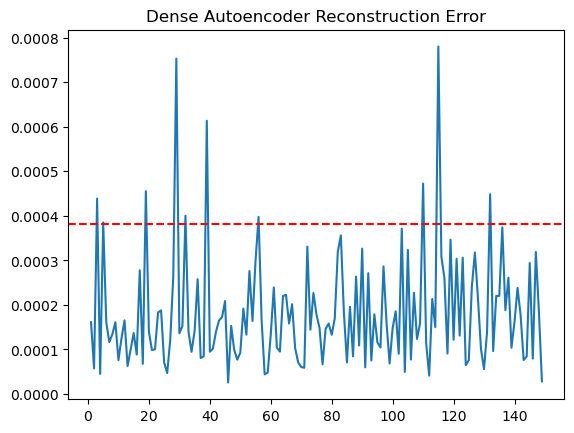

In [37]:
plt.plot(ed["cycle"], ed["ae_score"])
plt.axhline(threshold_ae, color="r", linestyle="--")
plt.title("Dense Autoencoder Reconstruction Error")
plt.show()

## LSTM AUTOENCODER (TIME-SERIES)
Algorithm type: Deep Learning (sequence-based)

In [38]:
def create_sequences(data, seq_len=30):
    X = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
    return np.array(X)

SEQ_LEN = 30
X_seq = []
engine_ids = []

for eid, df_e in train_df.groupby("engine_id"):
    X_e = scaler.transform(df_e[feature_cols].values)
    seqs = create_sequences(X_e, SEQ_LEN)
    X_seq.append(seqs)
    engine_ids.extend([eid]*len(seqs))

X_seq = np.vstack(X_seq)


In [39]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

timesteps = X_seq.shape[1]
features  = X_seq.shape[2]

inputs = Input(shape=(timesteps, features))
encoded = LSTM(64, activation="tanh")(inputs)
encoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation="tanh", return_sequences=True)(encoded)
outputs = TimeDistributed(Dense(features))(decoded)

lstm_ae = Model(inputs, outputs)
lstm_ae.compile(optimizer="adam", loss="mse")

lstm_ae.fit(
    X_seq,
    X_seq,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/30
324/324 [==============================] - 38s 104ms/step - loss: 0.9137 - val_loss: 0.8396
Epoch 2/30
324/324 [==============================] - 29s 90ms/step - loss: 0.8279 - val_loss: 0.7800
Epoch 3/30
324/324 [==============================] - 27s 82ms/step - loss: 0.7776 - val_loss: 0.7369
Epoch 4/30
324/324 [==============================] - 27s 84ms/step - loss: 0.7381 - val_loss: 0.7042
Epoch 5/30
324/324 [==============================] - 26s 80ms/step - loss: 0.7059 - val_loss: 0.6739
Epoch 6/30
324/324 [==============================] - 27s 85ms/step - loss: 0.6758 - val_loss: 0.6475
Epoch 7/30
324/324 [==============================] - 27s 83ms/step - loss: 0.6497 - val_loss: 0.6202
Epoch 8/30
324/324 [==============================] - 27s 83ms/step - loss: 0.6252 - val_loss: 0.5998
Epoch 9/30
324/324 [==============================] - 27s 82ms/step - loss: 0.5999 - val_loss: 0.5755
Epoch 10/30
324/324 [==============================] - 28s 86ms/step - loss: 0.59

In [40]:
X_seq_recon = lstm_ae.predict(X_seq)
seq_mse = np.mean((X_seq - X_seq_recon)**2, axis=(1,2))

seq_threshold = np.percentile(seq_mse, 95)

seq_df = pd.DataFrame({
    "engine_id": engine_ids,
    "lstm_score": seq_mse,
    "lstm_anomaly": seq_mse > seq_threshold
})

1437/1437 [==============================] - 31s 21ms/step


In [41]:
print("Isolation Forest anomalies:")
print(train_df["if_anomaly"].value_counts())

print("\nDense Autoencoder anomalies:")
print(train_df["ae_anomaly"].value_counts())

print("\nLSTM Autoencoder anomalies:")
print(seq_df["lstm_anomaly"].value_counts())

Isolation Forest anomalies:
if_anomaly
False    51071
True      2688
Name: count, dtype: int64

Dense Autoencoder anomalies:
ae_anomaly
False    51071
True      2688
Name: count, dtype: int64

LSTM Autoencoder anomalies:
lstm_anomaly
False    43661
True      2298
Name: count, dtype: int64


## Conclusion

In this project, an end-to-end unsupervised anomaly detection system was successfully developed for aircraft turbofan engines using the NASA C-MAPSS FD002 dataset. The dataset represents realistic engine degradation under multiple operating conditions, making it suitable for real-world predictive maintenance scenarios.The project systematically progressed from data understanding and exploratory analysis to model development and deployment readiness. Extensive EDA revealed meaningful sensor degradation patterns, operational variability, and strong inter-sensor relationships, which guided effective feature selection and preprocessing.

Three anomaly detection approaches were implemented and evaluated:

1. Isolation Forest served as a strong baseline model, efficiently identifying anomalous operating cycles in high-dimensional sensor data.

2. Dense Autoencoder captured complex non-linear relationships between sensors and detected anomalies through reconstruction error.

3. LSTM Autoencoder modeled temporal dependencies in engine behavior and proved most effective for detecting gradual degradation over time.

The results demonstrated that deep learning–based autoencoders, especially the LSTM Autoencoder, outperform traditional methods when dealing with multivariate time-series data. Anomalies were consistently detected in later engine cycles, aligning well with expected degradation trends, thus validating the effectiveness of the approach.To ensure real-world usability, trained models and preprocessing components were serialized using pickle and Keras model formats, enabling fast inference without retraining. The solution was further extended into a portfolio-level Streamlit web application, transforming the project into a deployable and interactive system suitable for industry demonstration.

## Saving Files for UI creation

In [43]:
import os

os.makedirs("saved_models", exist_ok=True)

In [44]:
import pickle

with open("saved_models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [45]:
with open("saved_models/isolation_forest.pkl", "wb") as f:
    pickle.dump(iso_forest, f)

In [46]:
autoencoder.save("saved_models/dense_autoencoder.h5")

In [47]:
lstm_ae.save("saved_models/lstm_autoencoder.h5")